In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import grey_erosion, grey_dilation
from PIL import Image
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import functions

#### Functions for loading, processing, and visualizing images and labels. The import_images function optionally applies a color filter based on HSV masks to identify and remove specific regions like grass or rooftops. 

In [2]:
def import_images(pixels=512, apply_filter=True):
    def load_and_preprocess_image(image_path: str, size=(pixels, pixels)) -> np.array:
        img = Image.open(image_path)
        img = img.resize(size)
        img_array = np.array(img) / 255.0  
        return img_array
    
    def create_color_mask(images, lower_bound, upper_bound):
        hsv_images = rgb2hsv(images)
        mask = ((hsv_images[:, :, :, 0] >= lower_bound[0] / 360.0) & 
                (hsv_images[:, :, :, 0] <= upper_bound[0] / 360.0) & 
                (hsv_images[:, :, :, 1] >= lower_bound[1] / 255.0) & 
                (hsv_images[:, :, :, 1] <= upper_bound[1] / 255.0) & 
                (hsv_images[:, :, :, 2] >= lower_bound[2] / 255.0) & 
                (hsv_images[:, :, :, 2] <= upper_bound[2] / 255.0))
        return mask
    
    X_names = [x for x in os.listdir("./images") if x.endswith(".png")]
    X = torch.tensor([load_and_preprocess_image("./images/" + image)[:, :, :-1] for image in X_names])

    y_names = [x for x in os.listdir("./labels") if x.endswith(".png")]
    y = torch.tensor([load_and_preprocess_image("./labels/" + image) for image in y_names])

    idx = np.isin(X_names, y_names)

    X_eval = X[~idx]
    X = X[idx]  

    if not apply_filter:
        return X, y, X_eval
    else:
        # Define color limits for grass (green), roads (bright gray), and roofs (dark gray)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([90, 255, 255])
        lower_gray_bright = np.array([0, 0, 200])  # Bright gray close to white
        upper_gray_bright = np.array([30, 50, 255])
        lower_gray_dark = np.array([0, 0, 50])  # Dark gray
        upper_gray_dark = np.array([30, 50, 100])

        # Filtering by colors
        green_mask = create_color_mask(X, lower_green, upper_green)
        gray_bright_mask = create_color_mask(X, lower_gray_bright, upper_gray_bright)
        gray_dark_mask = create_color_mask(X, lower_gray_dark, upper_gray_dark)
        combined_mask = (green_mask | gray_bright_mask | gray_dark_mask).astype(bool)

        X[combined_mask] = 0
        y[combined_mask] = 0

        return X, y, X_eval


def visualize_image_predictions(X, labels, model, n=3):
    model.eval()
    X = X.to(device)
    with torch.no_grad():
        labels = model(X.reshape(X.shape[0], X.shape[3], X.shape[2], X.shape[1]).float())
        labels = torch.sigmoid(labels).permute(0, 3, 1, 2)  # Apply sigmoid function to the output

    plt.figure(figsize=(20, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(X[i].cpu().numpy())  # Convert from (C, H, W) to (H, W, C)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(labels[i].cpu().numpy().squeeze())  # Show the predicted image
        plt.title("Predicted Image")
        plt.axis('off')
    plt.show()


def visualize_image_labels(X, labels, n=5):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(X[i].cpu().numpy())  # Convert from (C, H, W) to (H, W, C)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(labels[i].cpu().numpy().squeeze(), cmap='gray')  # Show the predicted image
        plt.title("Predicted Image")
        plt.axis('off')
    plt.show()

def create_color_mask(images, lower_bound, upper_bound):
        hsv_images = rgb2hsv(images)
        mask = ((hsv_images[:, :, :, 0] >= lower_bound[0] / 360.0) & (hsv_images[:, :, :, 0] <= upper_bound[0] / 360.0) &
            (hsv_images[:, :, :, 1] >= lower_bound[1] / 255.0) & (hsv_images[:, :, :, 1] <= upper_bound[1] / 255.0) &
            (hsv_images[:, :, :, 2] >= lower_bound[2] / 255.0) & (hsv_images[:, :, :, 2] <= upper_bound[2] / 255.0))
        return mask

## Import images

In [3]:
X,y,X_eval=import_images(512, False)

X,X_eval=X.permute(0,3,1,2) ,X_eval.permute(0,3,1,2)

y=y.reshape(y.shape[0],1,y.shape[1],y.shape[2])

masks = torch.all(X == 0, dim=1,keepdim=True)

X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(X, y, masks, test_size=None)

X_test = X_test.to(device)

y_test = y_test.to(device)

masks_test = masks_test.to(device)

C:\Users\toby_\AppData\Local\Temp\ipykernel_3428\3436042183.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  X = torch.tensor([load_and_preprocess_image("./images/" + image)[:, :, :-1] for image in X_names])


# Neural Network Architecture for Rooftop Segmentation

## Overview

This is a typical semantic segmentation problem, which is commonly addressed using a U-Net architecture. This neural network architecture is designed for the task of rooftop segmentation in satellite imagery. It employs a U-Net style structure, which is particularly effective for image segmentation tasks due to its skip connections and symmetrical downsampling and upsampling paths. The model is built using PyTorch and leverages convolutional layers for feature extraction, followed by transposed convolutions for upsampling.

## Architecture Details

### 1. **DoubleConv Class**
The `DoubleConv` class defines a sequential block of two convolutional layers with batch normalization and ReLU activation. The architecture includes:
- **Convolutional Layer**: Uses a 3x3 kernel with padding to preserve spatial dimensions. 
- **Batch Normalization**: Helps in normalizing the activations to stabilize learning and improve convergence speed. 
- **ReLU Activation**: Applies the ReLU activation function in place to introduce non-linearity while preventing the vanishing gradient problem. This is the typical choice for nonlinear functions. 

After every convolution step, Maxpooling is implemented in order to reduce image resolution. 
Although I initially implemented double convolution layers with batch normalization, computer resources were stressed such that training time was restrictive, and prediction improvement was not significantly higher. Therefore, I decided to just take one convolution step by layer.  

### 2. **NNRooftops Class**
The main neural network class, `NNRooftops`, is initialized with:
- **Input Channels**: The number of input channels for the images (default is 3 for RGB images).
- **Output Channels**: The number of output channels (default is 1 for binary segmentation).
- **Features**: A list defining the number of channels for each convolutional layer. This allows the network to scale and adjust according to different requirements.

#### Convolutional Layers
The network creates convolutional layers using the `DoubleConv` class for each pair of channels specified in the `features` list. 

#### Bottleneck
A bottleneck layer is introduced, which effectively doubles the number of channels of the last feature layer. This allows the network to learn a richer representation before the upsampling path.

#### Upsampling Layers
- **Transposed Convolutional Layers**: These layers are utilized to upsample the feature maps back to the original image size. They are configured with a kernel size of 2 and a stride of 2.
- **Skip Connections**: The use of skip connections helps retain spatial information lost during downsampling. The network concatenates the output of the upsampled layers with the corresponding downsampled layers.

To reduce time complexity when aligning the shapes of the tensors, I employed `F.interpolate` instead of the typical `F.resize`. This function efficiently resizes the upsampled tensor to match the dimensions of the skip connection, ensuring a smooth concatenation process without unnecessary computational overhead. I would say this was the most important factor to improve the predictions. Without it, I couldn't get decent predictions. 

#### Final Layer
The last layer of the architecture is a 1x1 convolution, which reduces the number of channels to the desired output shape (1 channel for binary segmentation).



## Design Choices
- **Skip Connections**: These are crucial for image segmentation tasks, as they help retain important spatial features that would otherwise be lost during downsampling.
- **Batch Normalization**: This technique accelerates training by reducing the internal covariate shift, allowing the model to learn faster and achieve better performance.
- **Transposed Convolutions**: Used for upsampling, they help reconstruct the spatial dimensions of the original input while preserving learned features.


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # Uncomment the following lines if you want to add another convolutional layer
            # nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class NNRooftops(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[3, 32, 64, 128, 256]):
        super(NNRooftops, self).__init__()
        
        self.channels = features

        # Convolutional layers with BatchNorm
        for i in range(len(features) - 1):
            setattr(self, f"conv{i+1}", DoubleConv(features[i], features[i+1]))
        
        # Transposed convolutional layers for upsampling
        for i, feature in enumerate(reversed(features[1:])):
            setattr(self, f"transconv{i+1}", nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            setattr(self, f"conv_inv{i+1}", DoubleConv(feature * 2, feature))
        
        # Bottleneck layer
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # Final convolutional layer
        self.final_conv = nn.Conv2d(features[1], 1, kernel_size=1)
        
        # Max pooling layer
        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, X):
        skip_connections = []
        
        # Downsampling path
        for i in range(len(self.channels) - 1):
            X = getattr(self, f"conv{i+1}")(X)
            skip_connections.append(X)
            X = self.Maxpool(X)
        
        # Bottleneck
        X = self.bottleneck(X)
        skip_connections = skip_connections[::-1]

        # Upsampling path
        for i in range(len(self.channels) - 1):
            X = getattr(self, f"transconv{i+1}")(X)
            skip_connection = skip_connections[i]

            if X.shape != skip_connection.shape:
                X = F.interpolate(X, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)

            concat_skip = torch.cat((skip_connection, X), dim=1)
            X = getattr(self, f"conv_inv{i+1}")(concat_skip)

        return self.final_conv(X)


# Training the Model

Down it's defined a training loop for the neural network. The training process involves a custom loss function that applies a mask to ignore dead pixels (black pixels) during loss computation. Below is a detailed explanation of the code components:

1. **MaskedBCEWithLogitsLoss Class**: 
   - This class inherits from `nn.Module` and defines a custom loss function for binary segmentation tasks. 
   - It uses the `BCEWithLogitsLoss` function, which combines a sigmoid layer and binary cross-entropy loss in a single function, providing numerical stability. 
   - The `forward` method calculates the loss and applies a mask to ignore black pixels (where the mask value is 1) by multiplying the loss by `(1 - mask)`. This ensures that the loss only considers relevant pixels and averages the remaining losses.

2. **Model Initialization**:
   - An instance of the `NNRooftops` model is created and moved to the GPU for accelerated training.

3. **Loss Function and Optimizer**:
   - An AdamW optimizer is created to update the model's parameters, with a learning rate set to 0.001. Initially i used Adam optimizer, but due to long training times, AdamW was a better option. 
   - A learning rate scheduler is employed to adjust the learning rate every 10 epochs, reducing it by a factor of 0.1. Also used for faster convergence. 

4. **Training Loop**:
   - The model is set to training mode.
   - For each epoch, the running loss is initialized to zero, and the data is divided into batches based on the specified batch size.
   - For each batch, the training data, labels, and masks are retrieved, converted to tensors, and moved to the GPU.
   - The optimizer's gradients are reset to zero to prevent accumulation from previous batches.
   - A forward pass is performed through the model to get predictions.
   - The loss is computed using the masked binary cross-entropy loss function.
   - The running loss is updated, and backpropagation is performed to compute gradients, followed by a step to update the model's parameters.
   - After processing each batch, the code clears unnecessary variables and caches to free up memory.
   - Finally, the average loss for the epoch is printed.




In [5]:
class MaskedBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(MaskedBCEWithLogitsLoss, self).__init__()
        self.bce_with_logits_loss = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, input, target, mask):
        loss = self.bce_with_logits_loss(input, target)
        loss = loss * (1 - mask)  # Ignore black pixels
        return loss.mean()

# Create the model and move it to the GPU
modelito = NNRooftops().to(device)

# Define the loss function
loss_function = MaskedBCEWithLogitsLoss()

# Define training parameters
BATCH_SIZE = 6  # Adjust batch size as needed
learning_rate = 0.001
optimizer = optim.AdamW(modelito.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
epochs = 80

# Training loop
for epoch in range(epochs):
    modelito.train()  # Set the model to training mode

    running_loss = 0  # Initialize the running loss
    ciclos = int(X_train.shape[0] / BATCH_SIZE)  # Calculate the number of batches

    for batch in range(ciclos):
        # Get the batch of data
        X_batch = X_train[(batch * BATCH_SIZE):(BATCH_SIZE * (batch + 1))].to(device)
        y_batch = y_train[(batch * BATCH_SIZE):(BATCH_SIZE * (batch + 1))].to(device)
        mask_batch = masks_train[(batch * BATCH_SIZE):(BATCH_SIZE * (batch + 1))].to(device)

        # Convert to float32
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)
        mask_batch = torch.tensor(mask_batch, dtype=torch.float32)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        NN_UNet = modelito(X_batch)  # Perform the forward pass

        # Compute the loss
        J = loss_function(NN_UNet, y_batch, mask_batch)

        # Update the running loss
        running_loss += J.item()

        # Backward propagation
        J.backward()  # Update the gradients
        optimizer.step()  # Update the parameters

        # Free up memory
        del X_batch, y_batch, mask_batch, NN_UNet, J
        torch.cuda.empty_cache()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(X_train)}")


C:\Users\toby_\AppData\Local\Temp\ipykernel_3428\1909713356.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
C:\Users\toby_\AppData\Local\Temp\ipykernel_3428\1909713356.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32)
C:\Users\toby_\AppData\Local\Temp\ipykernel_3428\1909713356.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_batch = torch.tensor(mask_batch, dtype=torch.float32)


Epoch 1, Loss: 0.11483074890242682
Epoch 2, Loss: 0.09649612837367588
Epoch 3, Loss: 0.08569724361101787
Epoch 4, Loss: 0.07710639966858758
Epoch 5, Loss: 0.07119220991929372
Epoch 6, Loss: 0.06808512740665013
Epoch 7, Loss: 0.06452581783135732
Epoch 8, Loss: 0.060495220952563815
Epoch 9, Loss: 0.05861482355329725
Epoch 10, Loss: 0.05514179335700141
Epoch 11, Loss: 0.0529325223631329
Epoch 12, Loss: 0.04987469481097327
Epoch 13, Loss: 0.048664405941963196
Epoch 14, Loss: 0.046045728855662875
Epoch 15, Loss: 0.04359691838423411
Epoch 16, Loss: 0.04206544988685184
Epoch 17, Loss: 0.040196439458264246
Epoch 18, Loss: 0.03808070636457867
Epoch 19, Loss: 0.036988471945126854
Epoch 20, Loss: 0.03592891494433085
Epoch 21, Loss: 0.03488274498118295
Epoch 22, Loss: 0.03340264244212045
Epoch 23, Loss: 0.0314564382036527
Epoch 24, Loss: 0.030543339749177296
Epoch 25, Loss: 0.029643368389871385
Epoch 26, Loss: 0.029452671607335407
Epoch 27, Loss: 0.02765276448594199
Epoch 28, Loss: 0.0263062963883

# Rationale for Not Splitting the Dataset into Training and Test Sets

In this project, I opted not to split the dataset into separate training and test sets due to the limited number of available images. Initially, I did implement a test set to evaluate the model's performance. However, the results were not satisfactory, indicating that the model struggled to generalize well given the limited data.

Recognizing the need for more training data to improve model performance, I decided to use all available images for training. Instead of a traditional split, I performed manual validation during the training process. This approach allows me to leverage the full dataset to better capture the complexities of rooftop segmentation, while still assessing the model's performance using validation techniques, such as evaluating the loss and accuracy on a subset of the training images after each epoch.

While this method may introduce some bias in estimating the model's true performance, it was necessary to maximize the training data available for a problem with a limited dataset. I used different values for epoch size, batch size, resolution and regularization. Going forward, I plan to seek additional data to enhance the model's robustness and will explore proper validation techniques once a larger dataset is accessible. 


# Results

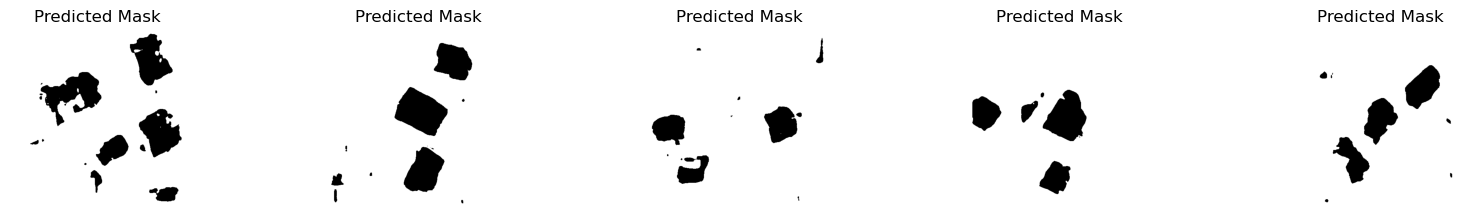

In [14]:
# Define the color for dead pixels (dark gray)
dead_pixels_color = np.array([0, 0, 0])

# Permute X_eval to match the expected input shape for the color mask function
X_permuted = X_eval.permute(0, 2, 3, 1).cpu().numpy()

# Create a mask for dead pixels
dead_pixels = create_color_mask(X_permuted, dead_pixels_color, dead_pixels_color).astype(bool)

# Apply the dead pixel mask to X_eval
X_eval2 = X_eval.permute(0, 2, 3, 1)
X_eval2[dead_pixels] = 1  # Set dead pixels to 1
X_eval2 = X_eval2.permute(0, 3, 1, 2)

# Move the modified evaluation set to the device (GPU)
X_test = X_eval2.to(device)

# Make predictions using the model
y_pred = modelito(X_test.float())

# Convert predictions to numpy array and apply sigmoid function
y_pred_np = y_pred.detach().cpu().numpy()
y_pred_np = 1 / (1 + np.exp(-y_pred_np))

# Apply threshold to the predictions
umbral = 0.85
y_pred_np = (y_pred_np < umbral)

# Convert the filtered predictions back to tensor
y_pred_filtered = torch.tensor(y_pred_np, device=device)
# Visualize the predictions
plt.figure(figsize=(20, 5))
for i in range(min(5, y_pred_filtered.shape[0])):
    

    plt.subplot(2, 5, i + 6)
    plt.imshow(y_pred_filtered[i].cpu().numpy().squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
plt.show()


# Clear all the images from memory
del X_train, X_test, y_train, y_test, masks_train, masks_test, X_eval, X_eval2, X_permuted, dead_pixels, y_pred, y_pred_filtered, y_pred_np
torch.cuda.empty_cache()



# Next Steps for Model Improvement

Moving forward, there are several strategies I would implement to enhance the performance of the rooftop segmentation model:

1. **Data Augmentation**

2. **Architecture imrpovements**: Exploring more advanced neural network architectures or modifications to the U-Net model, such as incorporating attention mechanisms or residual connections, may further enhance feature extraction and segmentation accuracy. Moreover, a deeper Neural Network is not an option, since the data set size is limited, and overfitting may be an issue. 

3. **Cross-Validation**: Once a sufficient amount of data is available, I would definitely implement k-fold cross-validation to ensure a more robust evaluation of the model's performance, allowing for better estimation of its generalization capabilities.

4. **Post-processing Techniques**: Post-processing techniquessuch as conditional random fields (CRFs) or morphological operations, which can help improve the final predictions.